# Earthquake Prediction Project V2

>Question: Build a full data pipleine which uses Machine Learning to predicts the Magnitude and Coordinates of the next earthquake.
​

Within this project I have created a local Data Engineering infrastructure using:
* Jupyter Lab - For scheduling daily jobs to retreive up to date Earthquake API results.
* MySQL - To store the historical earthquake dataset and predicted earthquake information.
* Power BI - To visualise additional trends and patterns of earthquakes.

Within this Jupyter notebook, I have gone through the Data Science pipeline and also implemented a Machine learning model. <br> Within this notebook, for the prediction of an earthquake, I have used:
- A Standard scaler to scale the features to unit variance.
- A Multivarient Linear Regression model with depth and time as the features.
- **Further Machine Learning evaluation by hyperparameter tuning the Linear Regression.**

​
**Data Dictionary**
- id : **Categorical**
- magnitude : **Quantitive**
- time : epoch format - **Quantitive**
- longitude : **Quantitive**
- latitude :  **Quantitive**
- depth :  **Quantitive**

​
I have added comments explaining the steps undertaken throughout this notebook.

# Extracting

### Importing & Data Cleaning

In [1]:
import requests
import json
import pandas as pd
import numpy as np

In [2]:
# We use this function to get the dataset
# FYI, the amount of earthquake with a magnitude of 5 or greater is large
# We only get the earthquakes since 23 August 2022.
# Additionally the dataset is large and can take sometime for the request to return
def fetch_earthqk_data(start_time, end_time):
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2000-01-01&endtime=now&limit=1000&orderby=time&minmagnitude=5"
    response = requests.get(url)
    data = json.loads(response.text)
    return data


In [3]:
# We define the start date as well as getting the latest earthquakes by specifiying the now value and call the get request function
start_time = "2000-01-01"
end_time = "now"
try:
    data = fetch_earthqk_data(start_time, end_time)
except Exception as e:
        print(f"Error fetching data from USGS' API: {e}")
        raise

In [4]:
# From testing the response.json from Postman, we'll need the unique ID, magnitude, datetime, longitude, latititude and depth. 
# The below features will be usful for our machine model. Try catches have been used as numerous formatting errors were caused from testing.
try:
    earthquakes = []
    for feature in data['features']:
        id = feature["id"]
        magnitude = feature['properties']['mag']
        time = feature['properties']['time']
        longitude, latitude, depth = feature['geometry']['coordinates']
        earthquakes.append([id, magnitude, time, longitude, latitude, depth])
except Exception as e:
    print(f"Error with formatting the response data: {e}")
    raise

In [5]:
df = pd.DataFrame(earthquakes, columns=['id', 'magnitude', 'time', 'longitude', 'latitude', 'depth'])
df.head()

,id,magnitude,time,longitude,latitude,depth
0,us6000k0pe,5.4,1680114409386,-173.0504,-15.2968,10.000
1,us6000k0il,5.1,1680080037792,127.9014,30.3087,6.485
2,us6000k0i7,5.0,1680075533484,178.4971,-26.2273,617.233
3,us6000k0bv,5.2,1680008837439,166.7573,-10.9198,9.181
4,us6000k0bq,5.0,1680008041794,166.8450,-10.8856,10.000


#### Interestingly, you can see the time in Epoch format already formatted for us for modelling.

# Transforming

### Exploratory Data Analysis

In [6]:
df.isnull().sum()

id           0
magnitude    0
time         0
longitude    0
latitude     0
depth        0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   time       1000 non-null   int64  
 3   longitude  1000 non-null   float64
 4   latitude   1000 non-null   float64
 5   depth      1000 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


In [8]:
df.describe()

,magnitude,time,longitude,latitude,depth
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,5.328230,1.671190e+12,34.371726,-0.011169,57.328038
std,0.426137,5.137050e+09,116.676469,31.033769,110.166981
min,5.000000,1.662282e+12,-179.966100,-65.407100,3.744000
25%,5.000000,1.666974e+12,-68.580375,-20.149225,10.000000
50%,5.200000,1.671115e+12,70.296300,-3.409900,15.000000
75%,5.500000,1.675724e+12,140.258000,26.609500,49.048500
max,7.800000,1.680114e+12,179.973800,72.518400,660.000000


In [9]:
df.shape

(1000, 6)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

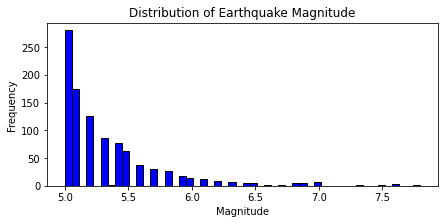

In [11]:
# Distribution of earthquake magnitudes
plt.figure(figsize=(7, 3))
plt.hist(df['magnitude'], bins=50, color='blue', edgecolor='black')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Earthquake Magnitude')
plt.show()

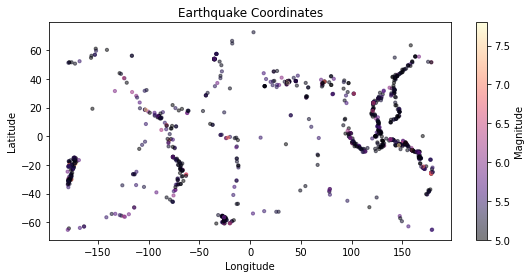

In [12]:
# A very visual visualisation of earthquake locations.
plt.figure(figsize=(9, 4))
plt.scatter(df['longitude'], df['latitude'], s=10, c=df['magnitude'], cmap='magma', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquake Coordinates')
plt.colorbar(label='Magnitude')
plt.show()

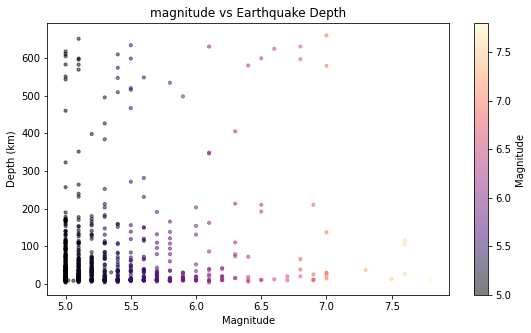

In [13]:
# We can see a weak negative correlation between depth and magnitude visually hear. 
# The higher the magnitude the higher the depth of the earthquake
plt.figure(figsize=(9, 5))
plt.scatter(df['magnitude'], df['depth'], s=10, c=df['magnitude'], cmap='magma', alpha=0.5)
plt.xlabel('Magnitude')
plt.ylabel('Depth (km)')
plt.title('magnitude vs Earthquake Depth')
plt.colorbar(label='Magnitude')
plt.show()

### Data Preprocessing

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

In [15]:
df.head()

,id,magnitude,time,longitude,latitude,depth
0,us6000k0pe,5.4,1680114409386,-173.0504,-15.2968,10.000
1,us6000k0il,5.1,1680080037792,127.9014,30.3087,6.485
2,us6000k0i7,5.0,1680075533484,178.4971,-26.2273,617.233
3,us6000k0bv,5.2,1680008837439,166.7573,-10.9198,9.181
4,us6000k0bq,5.0,1680008041794,166.8450,-10.8856,10.000


In [16]:
# From researching, time and depth are the best features to predict the magnitude and coordinates.
X = df[['time', 'depth']]
y = df[['magnitude', 'latitude', 'longitude']]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# Convert epoch timestamp to datatime format
df['time'] = pd.to_datetime(df['time'], unit='ms')

### Data Modelling

In [20]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [21]:
# We undergo our prediction
y_pred = model.predict(X_test_scaled)

In [22]:
# Checking the predicted value
print(y_pred[0])

[ 5.32768919 -0.45634331 34.34781142]


In [23]:
# We evaluate the accuracy of our score
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

### Evaluation

In [24]:
# We can see our evaluation values needs improvements. 
# Especially with our R squared with the relationship of the two variables explains 1% of the variation of the data.
# We can see our Mean Absolute Error is high as well .
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 43.493040119813294
Mean Squared Error: 5002.514995152671
Root Mean Squared Error: 70.72845958419192
R-squared: 0.008345431918594381


In [25]:
# We now predict the magnitude and coordinates of the next earthquake
# If a earthquake happened now with the depth of (), it would have the 'magnitude', 'latitude', 'longitude'

In [26]:
import datetime
import random

In [27]:
# Current date and time
current_time = datetime.datetime.now()

# Generate a random depth value that ranges from 0 and 700
new_depth = round(random.uniform(0, 700), 1)

# Convert the new time to Unix timestamp so it can be scaled
new_time_unix = int(current_time.timestamp())

#We create a dataframe so feature names are not lost when scaling the two features
predicting_data = pd.DataFrame([[new_time_unix, new_depth]], columns=['time', 'depth'])

# We now standardise the new time and depth values using the same scaler used from the training data
new_data_scaled = scaler.transform(predicting_data)

In [28]:
print(current_time)

2023-03-29 21:42:03.315019


In [29]:
# We now predict for the new time and depth values
new_prediction = model.predict(new_data_scaled)

In [30]:
# We check the magnitude, latitude, and longitude for the next earthquake
print(f"Predicted magnitude for Next Earthquake: {new_prediction[0][0]}")
print(f"Predicted latitude for Next Earthquake: {new_prediction[0][1]}")
print(f"Predicted longitude for Next Earthquake: {new_prediction[0][2]}")

Predicted magnitude for Next Earthquake: 8.775192482272598
Predicted latitude for Next Earthquake: -554.1462296115136
Predicted longitude for Next Earthquake: 585.2252516251448


##### We can see from the R2, MSE and MAE that our model is very inaccurate.
##### Additionally, the latitude and longitude isn't a valid coordinate 

### Hyperparameter tuning

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

In [32]:
# We undergo our data modelling with hyperparameter tuning
ridge = Ridge()
params = {'alpha': np.logspace(-4, 4, 100)}

# We use Gridsearch with a cross-validated of 5
grid_search = GridSearchCV(ridge, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_scaled, y_train)

# This is our best model
best_model = grid_search.best_estimator_

# We do our prediction using the best model
y_pred = best_model.predict(X_test_scaled)

In [33]:
# We evaluate and display the errornous of our model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 43.72775142741742
Mean Squared Error: 5009.861403794011
Root Mean Squared Error: 70.78037442535897
R-squared: -0.0017872630664457212


In [34]:
# We again use the current_time and a random depth value and standardise them using .transform.
current_time = datetime.datetime.now()
new_depth = round(random.uniform(0, 700), 1)
new_time_unix = int(current_time.timestamp())
predicting_data = pd.DataFrame([[new_time_unix, new_depth]], columns=['time', 'depth'])
new_data_scaled = scaler.transform(predicting_data)

# We predict the next earthquake
new_prediction = best_model.predict(new_data_scaled)

print(f"Predicted magnitude for Next Earthquake: {new_prediction[0][0]}")
print(f"Predicted latitude for Next Earthquake: {new_prediction[0][1]}")
print(f"Predicted longitude for Next Earthquake: {new_prediction[0][2]}")

Predicted magnitude for Next Earthquake: 5.592723151270904
Predicted latitude for Next Earthquake: -42.26811267151862
Predicted longitude for Next Earthquake: 74.96417659552381


##### The coordinates and magnitude is more accurate, however,
##### we can see that after hyper tuning our model that our model is actually worse with a R2: -0.0017...
##### This is odd even though our coordiates and magnitude is more accurate.
##### I'll need to reevaluate the choices of the independent variables I've chosen for a more accurate Linear Regression model.
##### More features with more complex models are needed to raise the error values which I beyond the scope of this project
##### In the next phase we load our data onto MySQL database which will be connected with PowerBI for further visualisation and summary.

# Loading onto MySQL

In [ ]:
import mysql.connector
from sqlalchemy import create_engine

In [ ]:
# Connect to MySQL db
try:
    user = 'root'
    password = 'admin'
    host = 'localhost'
    database = 'earthquake'

    connection_string = f"mysql+mysqlconnector://{user}:{password}@{host}/{database}"
    engine = create_engine(connection_string)
except Exception as e:
    print(f"Error establishing connection to MySQL database: {e}")
    raise

In [ ]:
# We create a table with the appropriate columns from our earquakes Dataframe in MySQL database
try:
    eq_table = 'earthquakes'

    create_table_query = f"""
    CREATE TABLE IF NOT EXISTS {eq_table} (
        id varchar(50) PRIMARY KEY,
        time DATETIME,
        magnitude DOUBLE,
        latitude DOUBLE,
        longitude DOUBLE,
        depth DOUBLE
        
    );
    """

    with engine.connect() as conn:
        conn.execute(create_table_query)
except Exception as e:
    print(f"Error creating table in database: {e}")
    raise

# We first delete the previous dataset before inserting the new list of earthquakes
try:
    delete_query = f"DELETE FROM {eq_table}"
    with engine.connect() as conn:
        conn.execute(delete_query)
        conn.close()
except Exception as e:
    print(f"Error deleting data from earthquakes table: {e}")
    raise

    
# We insert the DataFrame data into earthquakes table
try:
    df.to_sql(eq_table, engine, if_exists='append', index=False)
    conn.close()
except Exception as e:
    print(f"Error inserting data into MySQL table: {e}")
    raise

In [ ]:
# We insert the predicted earthquakes into a new table
try:
    predicted_eq = 'predicted_eq'

    create_predicted_table_query = f"""
    CREATE TABLE IF NOT EXISTS {predicted_eq} (
        id INT AUTO_INCREMENT PRIMARY KEY,
        predicted_magnitude DOUBLE,
        predicted_latitude DOUBLE,
        predicted_longitude DOUBLE,
        current_datetime DATETIME,
        random_depth DOUBLE
    );
    """

    with engine.connect() as conn:
        conn.execute(create_predicted_table_query)
        conn.close()
except Exception as e:
    print(f"Error creating table for predicted data in MySQL database: {e}")
    raise
    
# We again delete the previous predcited equakes for now before inserting new data
try:
    delete_query = f"DELETE FROM {predicted_eq}"
    with engine.connect() as conn:
        conn.execute(delete_query)
        conn.close()
except Exception as e:
    print(f"Error deleting data from MySQL table: {e}")
    raise

In [ ]:
# Finally, we insert the predicted data into the MySQL table
try:

    insert_predicted_data_query = f"""
    INSERT INTO {predicted_eq} (`predicted_magnitude`, `predicted_latitude`, `predicted_longitude`, `current_datetime`, `random_depth`)
    VALUES ({round(new_prediction[0][0], 2)}, {new_prediction[0][1]}, {new_prediction[0][2]}, '{current_time}', '{new_depth}');
    """

    with engine.connect() as conn:
        conn.execute(insert_predicted_data_query)
        conn.close()
except Exception as e:
    print(f"Error inserting predicted data into MySQL table: {e}")
    raise

##### From here onwards, the data will be accessible via PowerBI for futher insight and visualisation for Data Analysts.
##### We've completed the ETL pipeline within this notebook.